# Initial Imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

df = pd.read_csv("./kieranFeatures_1-30_26-Sep-2024.csv").drop(columns = "ID")
df.head()

,EDA_TonicMean_version02,EDA_TonicMean_version03,EDA_TonicMean_version04,EDA_TonicMean_version05,EDA_TonicMean_version09,EDA_TonicMean_version10,EDA_TonicMean_version11,EDA_TonicMean_version12,EDA_TonicMean_version16,EDA_TonicMean_version17,...,EEG_avgRelTheta_version16,EEG_avgRelTheta_version17,EEG_avgRelTheta_version19,EEG_avgRelTheta_version20,EEG_avgRelTheta_version22,EEG_avgRelTheta_version23,adjSA1,adjSA2,adjSA3,adjSAtotal
0,-0.123031,-0.226077,-1.220480,-1.697738,-0.273200,-0.601171,-0.809518,-1.012558,-0.299118,-0.469374,...,-1.877017,-1.442056,1.070298,1.277417,0.249605,0.400156,0.119790,1.593122,-0.800726,0.350233
1,-0.152896,-0.050866,1.527067,1.883468,-0.378060,-0.018812,1.023216,1.189124,-0.355315,-0.160570,...,-1.632698,-1.531970,1.779032,1.074498,0.409991,0.333842,0.075246,-1.663383,0.859309,-0.262893
2,-0.166035,-0.181478,1.634437,0.904620,-0.424192,-0.452936,1.123414,0.534554,-0.380039,-0.390771,...,-1.489450,-1.448590,2.194570,1.262672,0.504028,0.395338,-1.072729,0.879836,-1.542415,-0.938513
3,-0.231095,-0.209571,1.654951,1.247081,-0.652624,-0.546311,1.214370,0.821624,-0.502463,-0.440284,...,-1.353433,-1.059878,2.589134,2.139926,0.593317,0.682023,-0.643181,-0.217332,0.945816,0.145041
4,-0.236090,-0.323013,-0.478244,-1.080788,-0.670161,-0.923364,-0.421866,-0.775114,-0.511862,-0.640221,...,-1.443846,-0.627980,2.326862,3.114644,0.533965,1.000560,-0.323098,0.712401,-1.473404,-0.642872


# Pre-Processing

Divide up dataframe into predictors and outcomes. Train-test-split the following data.

In [30]:
# Create binary variables for high and low 
adj_SA_1_median = np.median(df["adjSA1"])
adj_SA_2_median = np.median(df["adjSA2"])
adj_SA_3_median = np.median(df["adjSA3"])
adj_SA_tot_median = np.median(df["adjSAtotal"])

# Will be high if adjusted SA level score is equal to or above median, low otherwise
df["Lv_1_Hi"] = (df["adjSA1"] >= adj_SA_1_median).astype(int)
df["Lv_2_Hi"] = (df["adjSA2"] >= adj_SA_2_median).astype(int)
df["Lv_3_Hi"] = (df["adjSA3"] >= adj_SA_3_median).astype(int)
df["Tot_Hi"] = (df["adjSAtotal"] >= adj_SA_tot_median).astype(int)

In [31]:
def split_data(df, n = 5814):
    # Separating predictors and outcomes
    predictors_df = df.iloc[:, 1:(df.shape[1] - 8)]
    predictors_df = predictors_df.sample(axis = "columns", n = n, replace = False, random_state = 42)
    outcomes_df = df.iloc[:, (df.shape[1] - 8):]

    # Split into train and test
    predictors_train, predictors_test, outcomes_train, outcomes_test = train_test_split(predictors_df, outcomes_df, test_size = 0.2, random_state = 42)

    # Scale the data
    scaler = StandardScaler()
    predictors_train = scaler.fit_transform(predictors_train)
    predictors_train = pd.DataFrame(predictors_train, columns = predictors_df.columns)
    predictors_test = scaler.transform(predictors_test)
    predictors_test = pd.DataFrame(predictors_test, columns = predictors_df.columns)

    return predictors_train, predictors_test, outcomes_train, outcomes_test

# Training Models

In [21]:
def n_features_cv_scores(df, n, outcome_var, folds):
    # Pre-Processing
    predictors_train, predictors_test, outcomes_train, outcomes_test = split_data(df, n)

    # Training Models
    # Setup models to train
    model = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)

    # Run CV and return mean of scores
    return np.mean(cross_val_score(model, predictors_train, outcomes_train[outcome_var], cv = folds, scoring = "accuracy", n_jobs = -1))

def top_n_features_LASSO_cv(df, n, outcome_var, folds):
    # Pre-Processing
    predictors_cv, predictors_test, outcomes_cv, outcomes_test = split_data(df)

    CV_scores = []
    # best_model = None
    # best_score = -1
    kf = KFold(n_splits = folds, shuffle = True, random_state = 42)

    # Select features based on training set, evaluate on validation set
    for i, (train_index, val_index) in enumerate(kf.split(predictors_cv)):
        predictors_train = predictors_cv.iloc[train_index]
        predictors_val = predictors_cv.iloc[val_index]
        outcomes_train = outcomes_cv.iloc[train_index]
        outcomes_val = outcomes_cv.iloc[val_index]

        # Initialize model with L1 Regularization (LASSO)
        model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000, fit_intercept = False)
        model.fit(predictors_train, outcomes_train[outcome_var])

        # Select Top n Features with LASSO
        selector = SelectFromModel(model, max_features = n, prefit = True, threshold = -np.inf)
        selected_features = selector.get_support(indices = True)

        predictors_train = predictors_train.iloc[:, selected_features]
        predictors_val = predictors_val.iloc[:, selected_features]

        # Evaluate model using selected features
        eval_model = LogisticRegression(solver = "liblinear", max_iter = 10000, fit_intercept = False)
        eval_model.fit(predictors_train, outcomes_train[outcome_var])
        accuracy = eval_model.score(predictors_val, outcomes_val[outcome_var])
        # if accuracy > best_score:
        #     best_model = eval_model
        CV_scores.append(accuracy)

    # return np.mean(CV_scores), eval_model
    return np.mean(CV_scores)

def top_n_features_RFE_cv(df, n, outcome_var, folds):
    # Pre-Processing
    predictors_cv, predictors_test, outcomes_cv, outcomes_test = split_data(df)

    CV_scores = []
    kf = KFold(n_splits = folds, shuffle = True, random_state = 42)

    # Select features based on training set, evaluate on validation set
    for i, (train_index, val_index) in enumerate(kf.split(predictors_cv)):
        predictors_train = predictors_cv.iloc[train_index]
        predictors_val = predictors_cv.iloc[val_index]
        outcomes_train = outcomes_cv.iloc[train_index]
        outcomes_val = outcomes_cv.iloc[val_index]

        # Initialize model with L1 Regularization (LASSO)
        model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 10000, fit_intercept = False)

        # Select n features with Recursive Feature Elimination
        rfe = RFE(estimator = model, n_features_to_select = n)
        rfe.fit

        # Select Top n Features with LASSO
        selector = SelectFromModel(model, max_features = n, prefit = True, threshold = -np.inf)
        selected_features = selector.get_support(indices = True)

        predictors_train = predictors_train.iloc[:, selected_features]
        predictors_val = predictors_val.iloc[:, selected_features]

        # Evaluate model using selected features
        eval_model = LogisticRegression(max_iter = 10000, fit_intercept = False)
        eval_model.fit(predictors_train, outcomes_train[outcome_var])
        accuracy = eval_model.score(predictors_val, outcomes_val[outcome_var])
        CV_scores.append(accuracy)

    return np.mean(CV_scores)

def n_features_test_accuracy(df, n, iters):
    SA_1_scores = []
    SA_2_scores = []
    SA_3_scores = []
    SA_tot_scores = []

    for _ in range(iters):
        # Pre-Processing
        predictors_train, predictors_test, outcomes_train, outcomes_test = split_data(df, n)

        # Training Models
        # Setup models to train
        SA_1_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
        SA_2_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
        SA_3_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
        SA_tot_LogReg = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)

        # Fit all models
        SA_1_LogReg.fit(predictors_train, outcomes_train["Lv_1_Hi"])
        SA_2_LogReg.fit(predictors_train, outcomes_train["Lv_2_Hi"])
        SA_3_LogReg.fit(predictors_train, outcomes_train["Lv_3_Hi"])
        SA_tot_LogReg.fit(predictors_train, outcomes_train["Tot_Hi"])



        # Model Evaluation
        # Get predictions for all models
        SA_1_preds = SA_1_LogReg.predict(predictors_test)
        SA_2_preds = SA_1_LogReg.predict(predictors_test)
        SA_3_preds = SA_1_LogReg.predict(predictors_test)
        SA_tot_preds = SA_1_LogReg.predict(predictors_test)

        # Append accuracy scores
        SA_1_scores.append(accuracy_score(outcomes_test["Lv_1_Hi"], SA_1_preds))
        SA_2_scores.append(accuracy_score(outcomes_test["Lv_2_Hi"], SA_2_preds))
        SA_3_scores.append(accuracy_score(outcomes_test["Lv_3_Hi"], SA_3_preds))
        SA_tot_scores.append(accuracy_score(outcomes_test["Tot_Hi"], SA_tot_preds))

    scores = {
        "SA_1": np.mean(SA_1_scores),
        "SA_2": np.mean(SA_2_scores),
        "SA_3": np.mean(SA_3_scores),
        "SA_Tot": np.mean(SA_tot_scores)
    }

    return scores 

In [ ]:
top_n_features_RFE_cv(df, 100, "Lv_1_Hi", 10)

In [22]:
n_vals = [5814, 2500, 1000, 500, 100]

reg_cv_scores = {
    "SA_1": [],
    "SA_2": [],
    "SA_3": [],
    "SA_Tot": []
}

LASSO_cv_scores = {
    "SA_1": [],
    "SA_2": [],
    "SA_3": [],
    "SA_Tot": []
}

# accuracy_scores = {
#     "SA_1": [],
#     "SA_2": [],
#     "SA_3": [],
#     "SA_Tot": []
# }

# Get CV Scores from different n features
for n in n_vals:
    print(n_features_cv_scores(df, n, "Lv_1_Hi", 10))
    print(top_n_features_LASSO_cv(df, n, "Lv_1_Hi", 10))
    print()

0.6713333333333333
0.6046666666666667

0.6586666666666666
0.6133333333333334

0.65
0.6098333333333333

0.604
0.5848333333333333

0.6211666666666668
0.5685



In [45]:
pred_train, pred_test, out_train, out_test = split_data(df)

# reg_model = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# reg_model.fit(pred_train, out_train["Tot_Hi"])
# print(reg_model.score(pred_test, out_test["Tot_Hi"]))

# LASSO_model = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 1000, fit_intercept = False)
# LASSO_model.fit(pred_train, out_train["Tot_Hi"])
# print(LASSO_model.score(pred_test, out_test["Tot_Hi"]))

RFE_model = LogisticRegression(solver = "liblinear", max_iter = 10000, fit_intercept = False)

rfe = RFE(estimator = RFE_model, n_features_to_select = 100, step = 12)
rfe.fit_transform(pred_train, out_train["Lv_1_Hi"])
print(rfe.support_)
print(rfe.ranking_)


[False False False ... False False False]
[156 361  45 ...  99 324  87]


In [46]:
reg_model = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
reg_model.fit(pred_train, out_train["Lv_1_Hi"])
print(reg_model.score(pred_test, out_test["Lv_1_Hi"]))

RFE_model.fit(pred_train.loc[:, rfe.support_], out_train["Lv_1_Hi"])
print(RFE_model.score(pred_test.loc[:, rfe.support_], out_test["Lv_1_Hi"]))

0.4918032786885246
0.639344262295082


Lasso Selecting 100 Features

In [78]:
for _ in range(10):
    print(top_n_features_cv(df, 100, "Lv_1_Hi", 10))

(np.float64(0.625), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.5508333333333333), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.625), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.54), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.625), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.6458333333333333), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.5625), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.56), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.5416666666666666), LogisticRegression(fit_intercept=False, max_iter=10000, solver='liblinear'))
(np.float64(0.5925), LogisticRegression(fit_intercept=False, max_iter=10000, solver='libl

In [35]:
n_vals.append("LASSO 100")

for SA_ver, level in [("SA_1", "Lv_1_Hi"), ("SA_2", "Lv_2_Hi"), ("SA_3", "Lv_3_Hi"), ("SA_Tot", "Tot_Hi")]:
    top_100_CV_scores, top_100_ACC_scores = top_100_features_cv_accuracy(df, level)
    cv_scores[SA_ver].append(top_100_CV_scores)
    accuracy_scores[SA_ver].append(top_100_ACC_scores)

NameError: name 'n_vals' is not defined

In [18]:
cv_scores_df = pd.DataFrame(data = cv_scores, index = n_vals)
test_accuracy_scores_df = pd.DataFrame(data = accuracy_scores, index = n_vals)

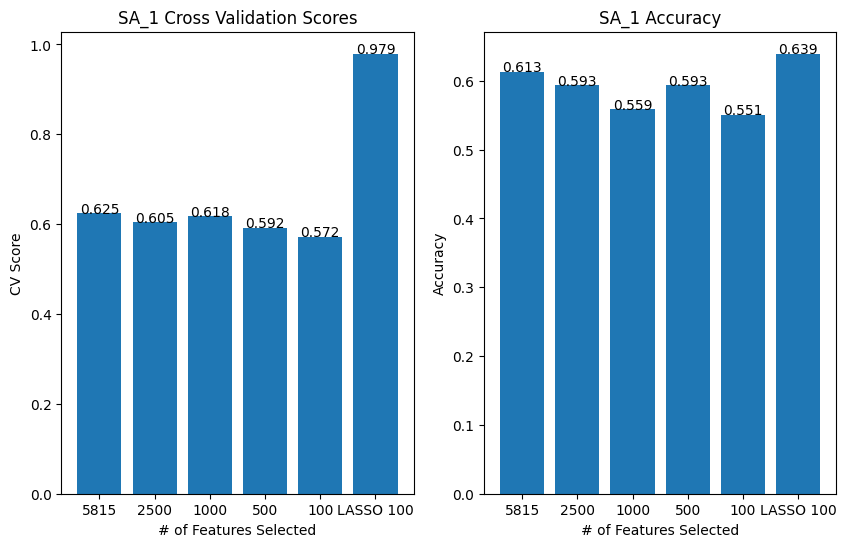

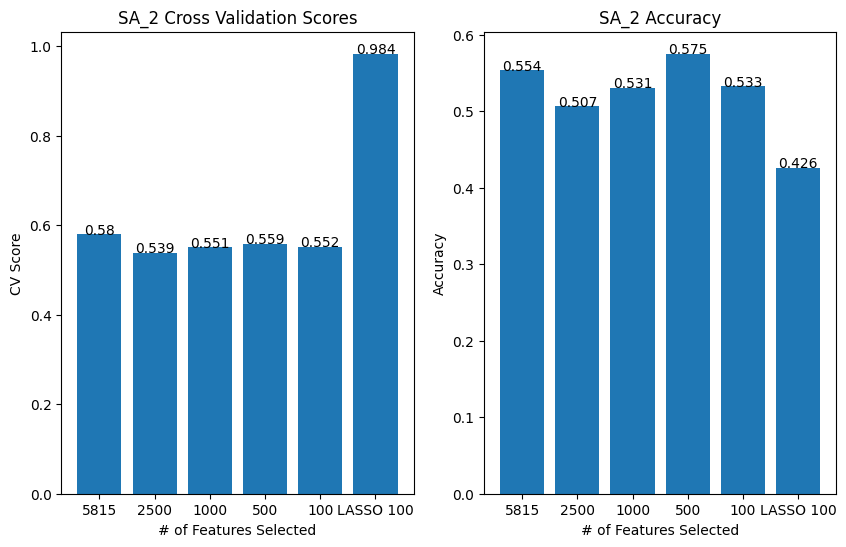

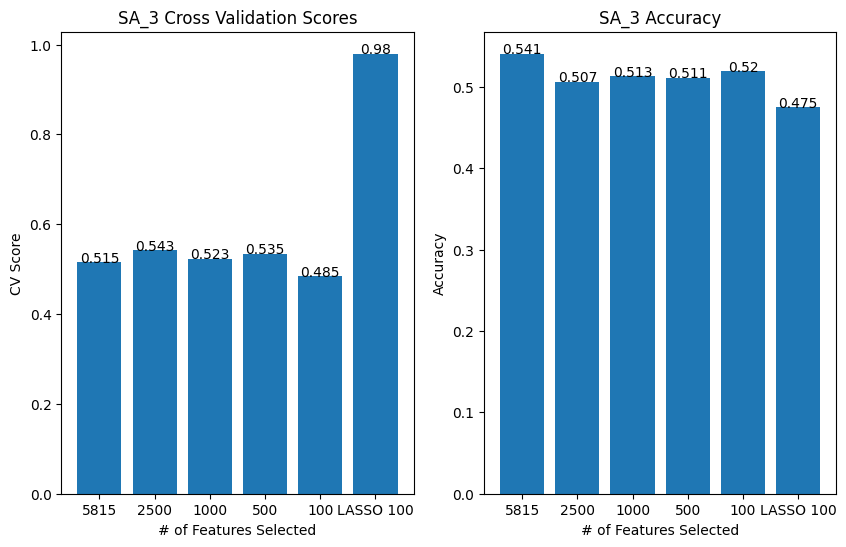

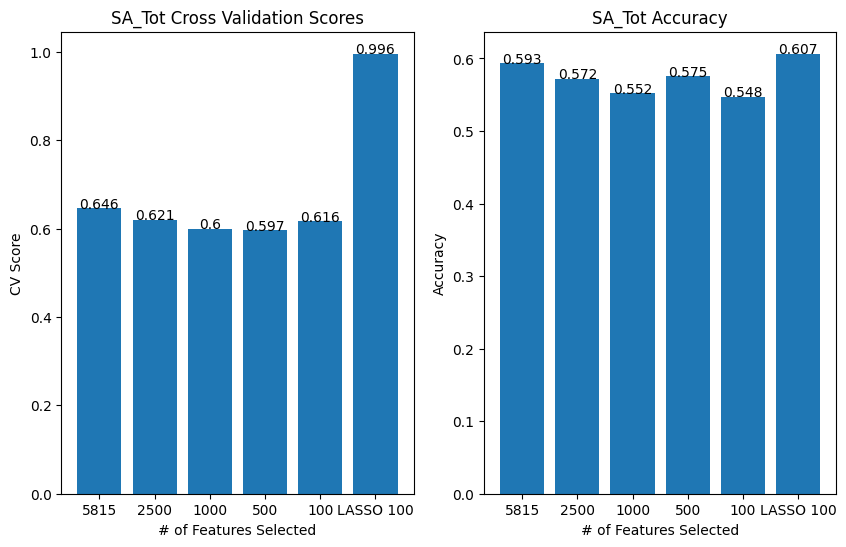

In [35]:
for SA_ver in ["SA_1", "SA_2", "SA_3", "SA_Tot"]:
    fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize = (10, 6))
    
    ax_1.bar([str(n) for n in n_vals], cv_scores_df[SA_ver].values)
    for n in n_vals:
        ax_1.text(str(n), cv_scores_df.loc[n, SA_ver], round(cv_scores_df.loc[n, SA_ver], 3), ha = "center")

    ax_1.set_title(SA_ver + " Cross Validation Scores")
    ax_1.set_xlabel("# of Features Selected")
    ax_1.set_ylabel("CV Score")

    ax_2.bar([str(n) for n in n_vals], test_accuracy_scores_df[SA_ver].values)
    for n in n_vals:
        ax_2.text(str(n), test_accuracy_scores_df.loc[n, SA_ver], round(test_accuracy_scores_df.loc[n, SA_ver], 3), ha = "center")
    ax_2.set_title(SA_ver + " Accuracy")
    ax_2.set_xlabel("# of Features Selected")
    ax_2.set_ylabel("Accuracy")

In [4]:
SA_1_LogReg_all = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
SA_1_LogReg_all.fit(predictors_train, outcomes_train["Lv_1_Hi"])

# SA_2_LogReg_5000 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_2_LogReg_5000.fit(predictors_train_5000, outcomes_train["Lv_2_Hi"])

# SA_3_LogReg_5000 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_3_LogReg_5000.fit(predictors_train_5000, outcomes_train["Lv_3_Hi"])

# SA_tot_LogReg_5000 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_tot_LogReg_5000.fit(predictors_train_5000, outcomes_train["Tot_Hi"])

SA_1_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
SA_1_LogReg_100.fit(predictors_train_100, outcomes_train["Lv_1_Hi"])

# SA_2_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_2_LogReg_100.fit(predictors_train_100, outcomes_train["Lv_2_Hi"])

# SA_3_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_3_LogReg_100.fit(predictors_train_100, outcomes_train["Lv_3_Hi"])

# SA_tot_LogReg_100 = LogisticRegression(max_iter = 10000, fit_intercept = False, n_jobs = -1)
# SA_tot_LogReg_100.fit(predictors_train_100, outcomes_train["Tot_Hi"])

LogisticRegression(fit_intercept=False, max_iter=10000, n_jobs=-1)

# Evaluating Model Performance (Accuracy)

In [5]:
def get_eval_metrics(model, predictors, outcome, display_labels):
    """
        Plots confusion matrix and ROC-AUC curve for a fitted sklearn model

        Parameters:
            model (sklearn Model): sklearn model to predict outcome values
            predictors (DataFrame): pandas Dataframe containing all predictor features
            outcome (Series): pandas Series containing all values for the outcome variable
            display_labels (list(str)): List of 2 strings for labeling the 0 and 1 outputs for confusion matrix

        Return:
            None
    """
    
    predicted_outcomes = model.predict(predictors)
    print("Accuracy: ", accuracy_score(predicted_outcomes, outcome))

    # Confusion Matrix
    predicted_outcomes = model.predict(predictors)
    cm = metrics.confusion_matrix(outcome, predicted_outcomes)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = display_labels)
    cm_display.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(outcome, predicted_outcomes)
    roc_auc  = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = "ROC Curve (area = %0.3f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--") # Random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

Accuracy:  0.4918032786885246


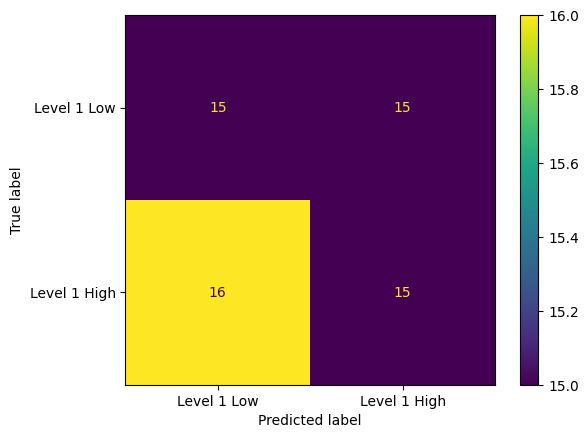

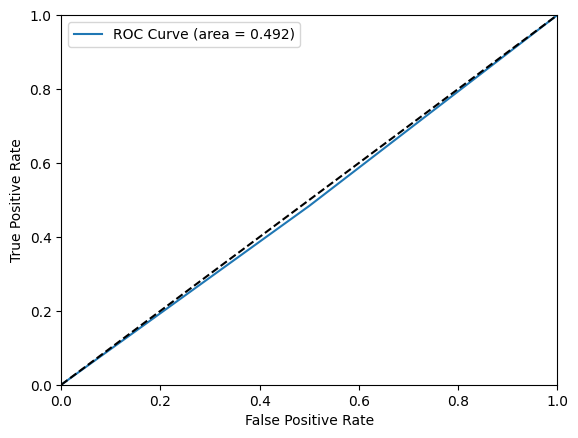

In [6]:
get_eval_metrics(SA_1_LogReg_all, predictors_test, outcomes_test["Lv_1_Hi"], ["Level 1 Low", "Level 1 High"])

Accuracy:  0.6229508196721312


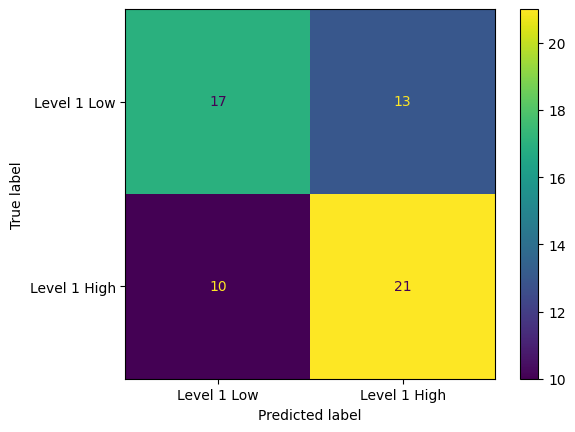

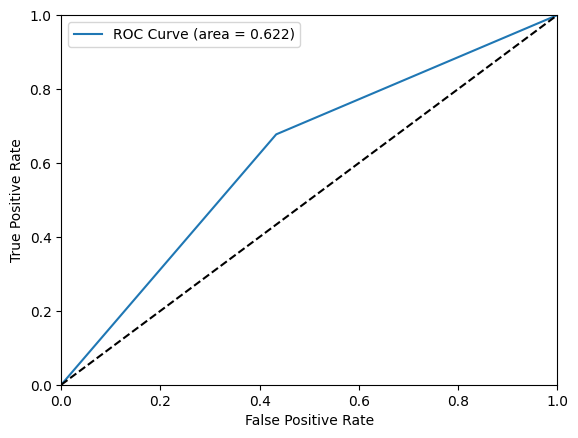

In [7]:
get_eval_metrics(SA_1_LogReg_100, predictors_test_100, outcomes_test["Lv_1_Hi"], ["Level 1 Low", "Level 1 High"])